In [81]:
%pylab inline
import matplotlib

Populating the interactive namespace from numpy and matplotlib


In [82]:
annotations_file_name = '/storage/BonnieH/selection_project/annotations/ccds.txt'
#sistr_file_name = '/storage/BonnieH/selection_project/per_locus/SISTR_results/SSC_scores.txt'
sistr_file_name = '/storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/SISTR_per_locus_scores_filt_w_total_thresh.txt'

In [83]:
def getNearestDist(s_ABC_round, s_list_available):
    min_dist = 100000000000000000000000000000000
    nearest_s = -2
    for elem in s_list_available:
        dist = abs(s_ABC_round - elem)
        if dist < min_dist:
            min_dist = dist
            nearest_s = elem
    return nearest_s

In [84]:
def main():
    # Get all TSS
    motif_to_use = 'AT'
    
    minus_tss = {}
    plus_tss = {}
    chrom_numbers = list(range(1,23))
    chrom_list = []
    print(chrom_numbers)

    for chrom in chrom_numbers:
        minus_tss['chr'+str(chrom)] = []
        plus_tss['chr'+str(chrom)] = []
        chrom_list.append('chr' + str(chrom))

    annotations_file = open(annotations_file_name, 'r')
    header = annotations_file.readline().strip().split('\t')
    
    # Get information from line
    for line in annotations_file:
        info = line.strip().split('\t')
        chrom = info[0]
        start = int(info[1])
        end = int(info[2])
        strand = info[5]
        if chrom in chrom_list:
            if strand == '+':
                if start not in plus_tss[chrom]:
                    plus_tss[chrom].append(start)

            if strand == '-':
                if end not in minus_tss[chrom]:
                    minus_tss[chrom].append(end)

    annotations_file.close()
    print(len(minus_tss))
    print(len(plus_tss))
    #for chrom in chrom_numbers:
        #print(len(plus_tss['chr'+str(chrom)]))
    #print(minus_tss[1])
    
    sistr_file = open(sistr_file_name, 'r')
    header = sistr_file.readline().strip().split('\t')

    x = []
    y = []
    i = 0
    j = 0
    bins = []
    scores = {}
    
    # Initialize scores dictionary
    start_bin = -10000 
    bin_incr =1000
    num_bins= int(20000/bin_incr)
    for l in range(0, num_bins):
        scores[start_bin] = []
        start_bin = start_bin + bin_incr
    
    # print(scores)
    # Get information from line
    for line in sistr_file:
        i = i + 1
        #if i%1000 == 0:
            #print(i)
        info = line.strip().split('\t')
        chrom = int(info[0])
        start = int(info[1])
        end = int(info[2])
        middle = int((start+end)/2)
        total = int(info[3])
        period = int(info[4])
        opt_allele = int(info[5])
        sistr_score = info[9]
        p_val = info[16]
        motif = info[6]
        if sistr_score != 'N/A' and period == 3 and opt_allele > 8: #and motif == motif_to_use: #total > 5214
            j = j +1 
            sistr_score = float(info[9])
            p_val = float(info[16])
            plus_list = plus_tss['chr'+str(chrom)]
            minus_list = minus_tss['chr'+str(chrom)]
            plus_closest = getNearestDist(middle, plus_list)
            minus_closest = getNearestDist(middle, minus_list)

            #plus_closest = closest(plus_list,end)
            #minus_closest = closest(minus_list,start)
            
            #if plus_closest - middle < 10000 and plus_closest-middle > -10000:
            if middle - plus_closest < 10000 and middle - plus_closest > -10000:
                x.append(middle - plus_closest)
                y.append(np.log10(sistr_score))
                distance = middle - plus_closest
                start_bin = -10000
                count = 0
                for k in range(0, num_bins):
                    if distance > start_bin and distance < start_bin + bin_incr:
                        if sistr_score < 10**-7:
                            sistr_score = 10**-6
                        #scores[start_bin].append(np.log10(sistr_score))
                        #scores[start_bin].append(sistr_score)
                        scores[start_bin].append(p_val)
                        count = count + 1
                    start_bin = start_bin + bin_incr
                if count != 1:
                    print('weird')
                
            if minus_closest - middle < 10000 and minus_closest - middle > -10000:
            #if middle - minus_closest < 10000 and middle - minus_closest > -10000:
                x.append(minus_closest - middle)
                y.append(np.log10(sistr_score))
                distance =  minus_closest - middle
                
                start_bin = -10000
                count = 0
                for k in range(0, num_bins):
                    if distance > start_bin and distance < start_bin + bin_incr:
                        if sistr_score < 10**-7:
                            sistr_score = 10**-6
                        #scores[start_bin].append(np.log10(sistr_score))
                        #scores[start_bin].append(sistr_score)
                        scores[start_bin].append(p_val)
                        count = count + 1
                    start_bin = start_bin + bin_incr
                if count != 1:
                    print('weird')
            
            '''
            if abs(plus_closest-middle) < abs(minus_closest-middle):
                distance = plus_closest-middle

            else:
                distance = middle-minus_closest
            if distance < 10000 and distance > -10000:
                
                x.append(distance)
                y.append(np.log10(sistr_score))
                
                start_bin = -10000
                count = 0
                for k in range(0, num_bins):
                    if distance > start_bin and distance < start_bin + bin_incr:
                        if sistr_score < 10**-7:
                            sistr_score = 10**-6
                        #scores[start_bin].append(np.log10(sistr_score))
                        scores[start_bin].append(sistr_score)
                        count = count + 1
                    start_bin = start_bin + bin_incr
                if count != 1:
                    print('weird')
            '''
            
    sistr_file.close()
    print(j)
    print(len(x))
    
    x_val = []
    y_val = []
    start_bin = -10000
    print('Size of each bin')
    for l in range(0, num_bins):
        score_list = scores[start_bin]
        
        print(len(score_list))
        #print(start_bin)
        num_zero = score_list.count(0)
        #print(num_zero/len(score_list)
        #print(np.mean(score_list))
        #print(len(score_list))
        #print(sum(i > 0.005 for i in score_list)/len(score_list))
        x_val.append(start_bin+int(bin_incr/2))
        #y_val.append(sum(i > 0.001 for i in score_list)/len(score_list))
        y_val.append(sum(i < 0.1 for i in score_list)/len(score_list))
        #y_val.append(num_zero/len(score_list))
        #y_val.append(np.mean(score_list))
        #y_val.append(np.median(score_list))
        start_bin = start_bin + bin_incr
        
    plt.figure(1)
    plt.plot(x_val,y_val,marker='o')
    plt.title('Period 3')# %s'%(motif_to_use))# %(motif_to_use)
    plt.xlabel('Distance to TSS')
    #plt.ylabel('Median s')
    #plt.ylabel('Mean s')
    #plt.ylabel('Percent s > 0.001')
    plt.ylabel('Percent LRT p < 0.1')
    plt.figure(2)
    plt.scatter(x,y,s=1)
    #plt.yscale('log')
    #plt.ylim(10**-6.5,0.3)
    plt.ylim(-6,0)
    print(y_val)
    
    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
22
22


/storage/BonnieH/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in log10
/storage/BonnieH/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log10


weird
weird
weird
weird
4388
725
Size of each bin
38
40
28
34
45
43
42
39
51
57
32
34
25
26
33
42
36
32
26
18
[0.5526315789473685, 0.5, 0.35714285714285715, 0.47058823529411764, 0.3333333333333333, 0.5581395348837209, 0.5952380952380952, 0.5641025641025641, 0.47058823529411764, 0.49122807017543857, 0.65625, 0.7058823529411765, 0.44, 0.4230769230769231, 0.2727272727272727, 0.42857142857142855, 0.5555555555555556, 0.5625, 0.6153846153846154, 0.5]
CPU times: user 1.49 s, sys: 26.3 ms, total: 1.51 s
Wall time: 1.48 s


/storage/BonnieH/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


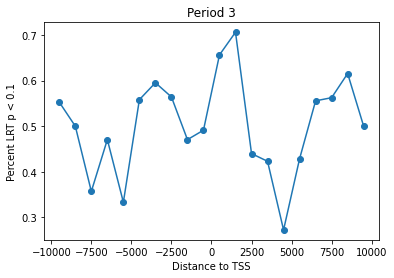

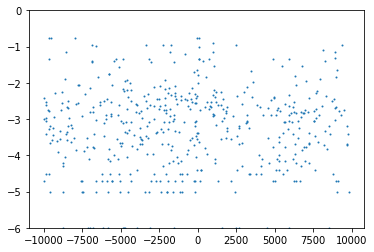

In [85]:
%%time
if __name__ == '__main__':
    main()